In [1]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')
import pandas as pd
import xarray as xr
from utils.paths import find
from scipy.interpolate import interp1d
from utils.format_data import format_frames
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from skimage.exposure import adjust_gamma
import matplotlib as mpl
mpl.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
from matplotlib.animation import FFMpegWriter
import subprocess
import wavio

In [2]:
base = 'fm1'
recording_path = os.path.join('/home/niell_lab/data/freely_moving_ephys/ephys_recordings/070921/J553RT/', base)
probe = 'DB_P128-6'
vidfile = '/home/niell_lab/Desktop/070921_J553RT_'+base+'.mp4'
audfile = '/home/niell_lab/Desktop/070921_J553RT_'+base+'.wav'
merge_mp4_name = '/home/niell_lab/Desktop/070921_J553RT_'+base+'_merge.mp4'
this_unit = 25
start = 0
has_top = (False if 'hf' in base else True)

In [3]:
ephys_h5 = pd.read_hdf(find('*ephys*.h5', recording_path)[0])
world_nc = xr.open_dataset(find('*world*.nc', recording_path)[0])
eye_nc = xr.open_dataset(find('*REYE*.nc', recording_path)[0])
if has_top is True:
    top_nc = xr.open_dataset(find('*TOP1*.nc', recording_path)[0])
eye_avi_path = find('*REYEdeinter.avi', recording_path)[0]
ephys_data = pd.read_json(find('*_ephys_merge.json', recording_path)[0])
ephysT0 = ephys_data.iloc[0,12]
del ephys_data
worldT = world_nc.timestamps - ephysT0

100%|█████████████████████████████████| 147790/147790 [01:59<00:00, 1232.70it/s]


In [38]:
eye_avi = format_frames(eye_avi_path, config=None, keep_size=True, use_xr=False)

100%|██████████████████████████████████| 147790/147790 [03:12<00:00, 765.88it/s]


In [4]:
eyeT = eye_nc.timestamps - ephysT0
# eye_vid = eye_nc.REYE_video.astype(np.uint8)
world_vid = world_nc.WORLD_video.astype(np.uint8)
del world_nc
eye_params = eye_nc.REYE_ellipse_params
goodcells = ephys_h5
units = goodcells.index.values

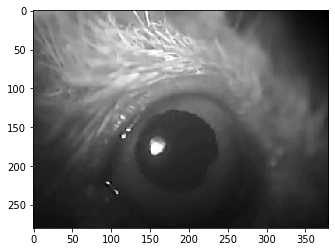

In [5]:
plt.imshow(eye_avi[100,200:,120:500], cmap='gray')

In [39]:
# new_eye_avi = np.empty(np.shape(eye_avi[:,200:,120:500]), dtype=np.uint8)
# for i in tqdm(range(np.size(eye_avi,0))):
#     new_eye_avi[i,:,:] = adjust_gamma(eye_avi[i,200:,120:500], 2.5).astype(np.uint8)
# del eye_avi
new_eye_avi = eye_avi[:,200:,120:500]

In [40]:
eyeInterp = interp1d(eyeT, new_eye_avi, axis=0, bounds_error=False)

In [8]:
worldInterp = interp1d(worldT, world_vid, axis=0, bounds_error=False)

In [9]:
if has_top:
    print('getting top video and timestamps')
    top_vid = top_nc.TOP1_video.astype(np.uint8)
    topT = top_nc.timestamps - ephysT0
    del top_nc
    print('interpolating top')
    topInterp = interp1d(topT, top_vid, axis=0,bounds_error=False)
    print('getting theta and phi')

getting top video and timestamps
interpolating top
getting theta and phi


In [10]:
th = eye_nc.REYE_ellipse_params.sel(ellipse_params='theta').values
phi = eye_nc.REYE_ellipse_params.sel(ellipse_params='phi').values
del eye_nc

In [11]:
if has_top:
    imu_data = xr.open_dataset(find('*imu*.nc', recording_path)[0])
    acc_chans = imu_data.IMU_data
    gz = np.array(acc_chans.sel(channel='gyro_z'))
    accT = ephys_h5[base+'_accT'].iloc[0]

[Text(0, 0, '0'),
 Text(0, 0, '2'),
 Text(0, 0, '4'),
 Text(0, 0, '6'),
 Text(0, 0, '8'),
 Text(0, 0, '10'),
 Text(0, 0, '12'),
 Text(0, 0, '14')]

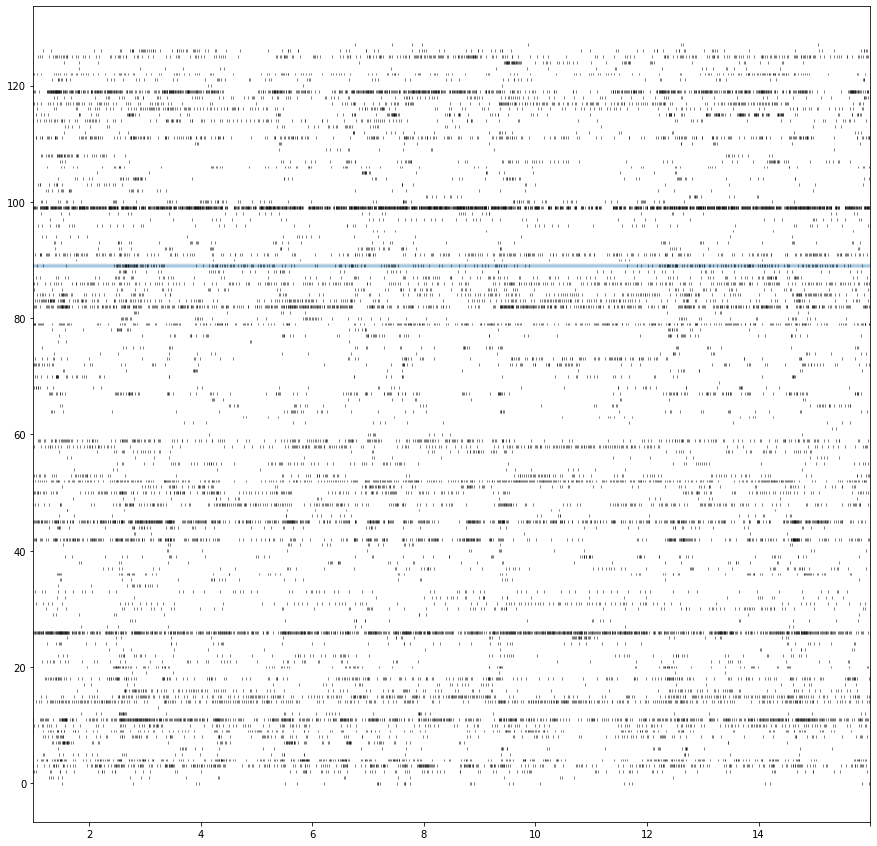

In [31]:
this_unit = 89
fig, ax = plt.subplots(1,1, figsize=(15,15))
plt.hlines(np.linspace(this_unit-0.25,this_unit+0.25,10), start,start+15,alpha=0.1,color='tab:blue') # this unit
for i, ind in enumerate(goodcells.index):
    plt.vlines(goodcells.at[ind,'spikeT'],i-0.25,i+0.25,'k',linewidth=0.5)
plt.xlim(start,start+15)
ax.set_xticklabels(np.arange(0,15,2))

(420, 1320)

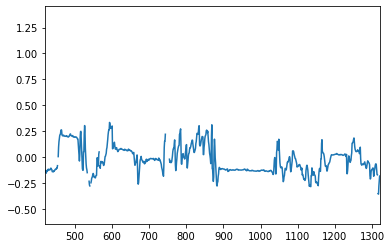

In [20]:
start = 7
x = start*60
plt.plot(th); plt.xlim([x,x+(60*15)])

[Text(0, 0, '0'),
 Text(0, 0, '2'),
 Text(0, 0, '4'),
 Text(0, 0, '6'),
 Text(0, 0, '8'),
 Text(0, 0, '10'),
 Text(0, 0, '12'),
 Text(0, 0, '14')]

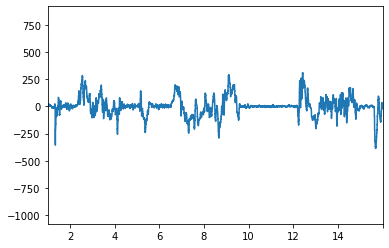

In [28]:
fig, ax = plt.subplots(1,1)
plt.plot(accT, gz); plt.xlim([start, start+15])
ax.set_xticklabels(np.arange(0,15,2))

In [32]:
this_unit = 89

(420, 1320)

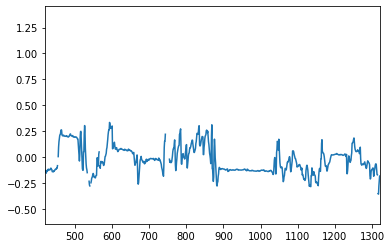

In [33]:
plt.plot(th)
plt.xlim([start*60,(start*60)+(15*60)])

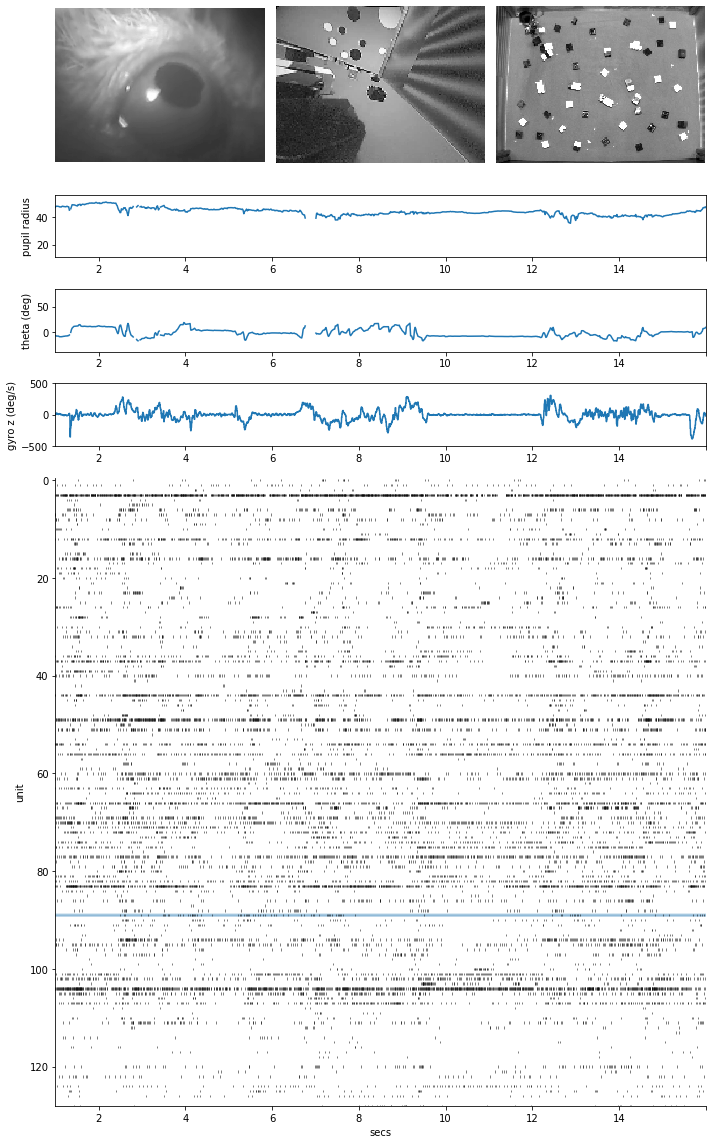

In [41]:
# set up figure
fig = plt.figure(figsize = (10,16))
gs = fig.add_gridspec(12,6)
if has_top:
    axEye = fig.add_subplot(gs[0:2,0:2])
    axWorld = fig.add_subplot(gs[0:2,2:4])
    axTopdown = fig.add_subplot(gs[0:2,4:6])
else:
    axEye = fig.add_subplot(gs[0:2,0:3])
    axWorld = fig.add_subplot(gs[0:2,3:6])
axRad = fig.add_subplot(gs[2,:])
axTh = fig.add_subplot(gs[3,:])
if has_top:
    axGyro = fig.add_subplot(gs[4,:])
    axR = fig.add_subplot(gs[5:12,:])
else:
    axR = fig.add_subplot(gs[4:12,:])

# timerange and center frame (only)
tr = [start, start+15]
fr = np.mean(tr) # time for frame
eyeFr = np.abs(eyeT-fr).argmin(dim = "frame")
worldFr = np.abs(worldT-fr).argmin(dim = "frame")
if has_top:
    topFr = np.abs(topT-fr).argmin(dim = "frame")

axEye.cla(); axEye.axis('off')
axEye.imshow(new_eye_avi[eyeFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")

axWorld.cla();  axWorld.axis('off'); 
axWorld.imshow(world_vid[worldFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")

if has_top:
    axTopdown.cla();  axTopdown.axis('off'); 
    axTopdown.imshow(top_vid[topFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")

axTh.cla()
axTh.plot(eyeT,np.rad2deg(th))
axTh.set_xlim(tr[0],tr[1]); 
axTh.set_ylabel('theta (deg)')#; axTh.set_ylim(-50,0)
axTh.set_xticklabels(np.arange(0,15,2))

axRad.cla()
axRad.plot(eyeT,eye_params.sel(ellipse_params='longaxis'))
axRad.set_xlim(tr[0],tr[1])
axRad.set_ylabel('pupil radius')
axRad.set_xticklabels(np.arange(0,15,2))

if has_top:
    # plot gyro
    axGyro.plot(accT,gz)
    axGyro.set_xlim(tr[0],tr[1]); axGyro.set_ylim(-500,500)
    axGyro.set_ylabel('gyro z (deg/s)')   
    axGyro.set_xticklabels(np.arange(0,15,2))

# plot spikes
axR.fontsize = 20
if '64' in probe:
    sh_num = 2
elif '128' in probe:
    sh_num = 4
sh0 = np.arange(0,len(goodcells.index)+sh_num,sh_num)
full_raster = np.array([]).astype(int)
for sh in range(sh_num):
    full_raster = np.concatenate([full_raster, sh0+sh])
axR.hlines(np.linspace(this_unit-0.25,this_unit+0.25,10), tr[0],tr[1],alpha=0.1,color='tab:blue') # this unit
for i, ind in enumerate(goodcells.index):
    i = full_raster[i]
    axR.vlines(goodcells.at[ind,'spikeT'],i-0.25,i+0.25,'k',linewidth=0.5)

n_units = len(goodcells)
axR.set_ylim(n_units,-.5)
axR.set_xlim(tr[0],tr[1]); axR.set_xlabel('secs'); axR.set_ylabel('unit')
axR.spines['right'].set_visible(False)
axR.spines['top'].set_visible(False)
axR.set_xticklabels(np.arange(0,15,2))
plt.tight_layout()

writer = FFMpegWriter(fps=30, extra_args=['-vf','scale=800:-2'])
with writer.saving(fig, vidfile, dpi=100):
    for t in np.arange(tr[0],tr[1],1/30):
        # show eye and world frames
        axEye.cla(); axEye.axis('off')
        axEye.imshow(eyeInterp(t),'gray',vmin=0,vmax=255,aspect = "equal")
        axWorld.cla(); axWorld.axis('off'); 
        axWorld.imshow(worldInterp(t),'gray',vmin=0,vmax=255,aspect = "equal")
        if has_top:
            axTopdown.cla(); axTopdown.axis('off')
            axTopdown.imshow(topInterp(t).astype(np.uint8),'gray',vmin=0,vmax=255,aspect = "equal")
        # plot line for time, then remove
        ln = axR.vlines(t,-0.5,n_units,'tab:blue')
        writer.grab_frame()
        ln.remove()

In [42]:
# timerange
tr = [start, start+15]
# generate wav file
sp = np.array(goodcells['spikeT'].iloc[np.argwhere(full_raster==this_unit)[0][0]])-tr[0]
sp = sp[sp>0]
datarate = 30000
# compute waveform samples
tmax = tr[1]-tr[0]
t = np.linspace(0, tr[1]-tr[0], (tr[1]-tr[0])*datarate, endpoint=False)
x = np.zeros(np.size(t))
for spt in sp[sp<tmax]:
    x[np.int64(spt*datarate) : np.int64(spt*datarate +30)] = 1
    x[np.int64(spt*datarate)+31 : np.int64(spt*datarate +60)] =- 1
# write the samples to a file
wavio.write(audfile, x, datarate, sampwidth=1)

In [43]:
subprocess.call(['ffmpeg', '-i', vidfile, '-i', audfile, '-c:v', 'copy', '-c:a', 'aac', '-y', merge_mp4_name])

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/home/niell_lab/anaconda3/envs/DLC-GPU1 --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7

0